In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# STEP 2: Extract archive (8).zip
import zipfile
import os

zip_path = "/content/drive/MyDrive/archive (8).zip"  # Change if different
extract_to = "/content/dataset"

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Confirm structure
os.listdir(extract_to)


['Data']

In [3]:
# STEP 3: Set Paths to Train/Test Folders
train_dir = "/content/dataset/Data/Train_Data"
test_dir = "/content/dataset/Data/Test_Data"

img_height, img_width = 150, 150
batch_size = 32
epochs = 25

num_classes = len(os.listdir(train_dir))


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

# === Step 1: Remove corrupt images
def clean_images(folder):
    bad = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            try:
                img = Image.open(path)
                img.verify()
            except (UnidentifiedImageError, OSError, IOError):
                print("Removing:", path)
                os.remove(path)
                bad += 1
    print(f"✅ Removed {bad} bad images from {folder}")

# Clean both train and test directories
clean_images("/content/dataset/Data/Train_Data")
clean_images("/content/dataset/Data/Test_Data")


Removing: /content/dataset/Data/Train_Data/Fire/F_781.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_69.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_81.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_770.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_938.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_600.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_677.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_759.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_909.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_875.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_779.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_590.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_937.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_743.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_82.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_758.jpg
Removing: /content/dataset/Data/Train_Data/Fire/F_704.jpg
Removing: /conten

In [5]:
# === Configuration ===
img_height, img_width = 224, 224
batch_size = 32
epochs_initial = 10
epochs_finetune = 10
train_dir = "/content/dataset/Data/Train_Data"
test_dir = "/content/dataset/Data/Test_Data"
num_classes = len(os.listdir(train_dir))

# === Data Preparation ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical', subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical', subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(img_height, img_width), batch_size=1,
    class_mode='categorical', shuffle=False
)


Found 3896 images belonging to 2 classes.
Found 974 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [6]:
# === Load MobileNetV2 Base Model ===
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# === Add Custom Classifier ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("mobilenet_fire_best.h5", save_best_only=True)

# === Initial Training ===
print("🔧 Starting initial training (top layers only)...")
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs_initial,
    callbacks=[early_stop, checkpoint]
)

# === Unfreeze Some Layers for Fine-Tuning ===
print("🔄 Fine-tuning MobileNetV2...")
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs_finetune,
    callbacks=[early_stop, checkpoint]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
🔧 Starting initial training (top layers only)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.6910 - loss: 0.6170

122/122 ━━━━━━━━━━━━━━━━━━━━ 96s 690ms/step - accuracy: 0.6918 - loss: 0.6157 - val_accuracy: 0.8901 - val_loss: 0.2752
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8981 - loss: 0.2516

122/122 ━━━━━━━━━━━━━━━━━━━━ 120s 566ms/step - accuracy: 0.8981 - loss: 0.2514 - val_accuracy: 0.9138 - val_loss: 0.2113
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 69s 570ms/step - accuracy: 0.9286 - loss: 0.1822 - val_accuracy: 0.9045 - val_loss: 0.2420
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 573ms/step - accuracy: 0.9454 - loss: 0.1495 - val_accuracy: 0.9086 - val_loss: 0.2387
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9452 - loss: 0.1462

122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 575ms/step - accuracy: 0.9452 - loss: 0.1461 - val_accuracy: 0.9179 - val_loss: 0.2042
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 81s 565ms/step - accuracy: 0.9593 - loss: 0.1164 - val_accuracy: 0.9209 - val_loss: 0.2074
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 584ms/step - accuracy: 0.9548 - loss: 0.1257 - val_accuracy: 0.9148 - val_loss: 0.2089
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9611 - loss: 0.1055

122/122 ━━━━━━━━━━━━━━━━━━━━ 69s 567ms/step - accuracy: 0.9610 - loss: 0.1056 - val_accuracy: 0.9240 - val_loss: 0.2041
Epoch 9/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9577 - loss: 0.1065

122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 574ms/step - accuracy: 0.9577 - loss: 0.1065 - val_accuracy: 0.9261 - val_loss: 0.1966
Epoch 10/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 571ms/step - accuracy: 0.9596 - loss: 0.1159 - val_accuracy: 0.9189 - val_loss: 0.2059
🔄 Fine-tuning MobileNetV2...
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 109s 704ms/step - accuracy: 0.8821 - loss: 0.3154 - val_accuracy: 0.9240 - val_loss: 0.2171
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9446 - loss: 0.1570

122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 576ms/step - accuracy: 0.9447 - loss: 0.1568 - val_accuracy: 0.9343 - val_loss: 0.1929
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9493 - loss: 0.1356

122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 584ms/step - accuracy: 0.9494 - loss: 0.1355 - val_accuracy: 0.9384 - val_loss: 0.1765
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9563 - loss: 0.1134

122/122 ━━━━━━━━━━━━━━━━━━━━ 73s 597ms/step - accuracy: 0.9563 - loss: 0.1134 - val_accuracy: 0.9425 - val_loss: 0.1696
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 572ms/step - accuracy: 0.9644 - loss: 0.0960 - val_accuracy: 0.9394 - val_loss: 0.1786
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9675 - loss: 0.0919

122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 576ms/step - accuracy: 0.9675 - loss: 0.0919 - val_accuracy: 0.9517 - val_loss: 0.1584
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 580ms/step - accuracy: 0.9701 - loss: 0.0783 - val_accuracy: 0.9425 - val_loss: 0.1743
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9708 - loss: 0.0800

122/122 ━━━━━━━━━━━━━━━━━━━━ 73s 601ms/step - accuracy: 0.9708 - loss: 0.0800 - val_accuracy: 0.9507 - val_loss: 0.1527
Epoch 9/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 574ms/step - accuracy: 0.9749 - loss: 0.0767 - val_accuracy: 0.9528 - val_loss: 0.1640
Epoch 10/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 586ms/step - accuracy: 0.9781 - loss: 0.0565 - val_accuracy: 0.9538 - val_loss: 0.1595


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


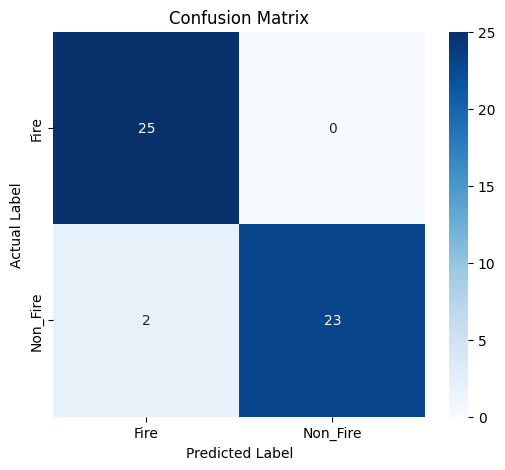


📋 Classification Report
              precision    recall  f1-score   support

        Fire     0.9259    1.0000    0.9615        25
    Non_Fire     1.0000    0.9200    0.9583        25

    accuracy                         0.9600        50
   macro avg     0.9630    0.9600    0.9599        50
weighted avg     0.9630    0.9600    0.9599        50


✅ Evaluation Summary
Accuracy       : 0.9600
Precision (avg): 0.9630
Recall    (avg): 0.9600
F1-score  (avg): 0.9599


In [7]:
# === Predictions ===
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# === Confusion Matrix Plot ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names),
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# === Classification Report ===
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\n📋 Classification Report")
print(report)

# === Metrics Summary ===
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n✅ Evaluation Summary")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision (avg): {prec:.4f}")
print(f"Recall    (avg): {rec:.4f}")
print(f"F1-score  (avg): {f1:.4f}")



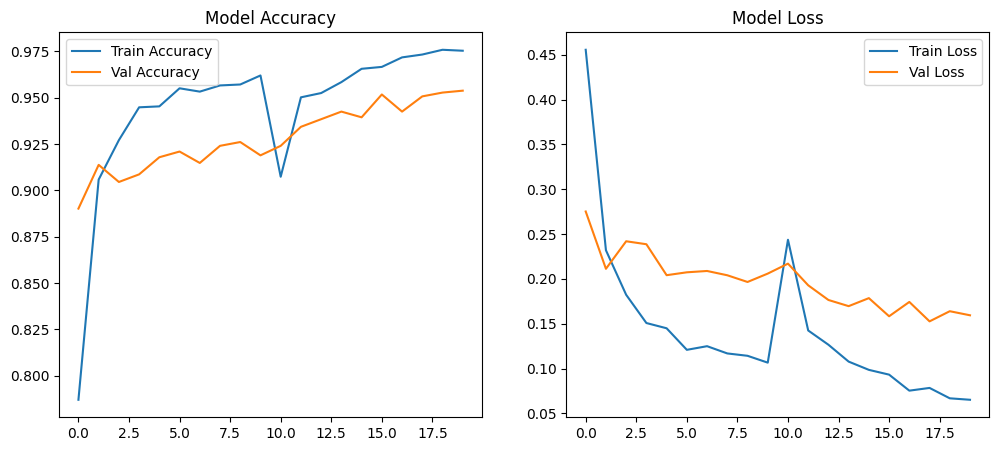

In [8]:
# === Plot Accuracy and Loss ===
plt.figure(figsize=(12, 5))

# Combine both histories
def combine_histories(h1, h2, key):
    return h1.history[key] + h2.history[key]

plt.subplot(1, 2, 1)
plt.plot(combine_histories(history1, history2, 'accuracy'), label='Train Accuracy')
plt.plot(combine_histories(history1, history2, 'val_accuracy'), label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(combine_histories(history1, history2, 'loss'), label='Train Loss')
plt.plot(combine_histories(history1, history2, 'val_loss'), label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()


In [10]:
# Save model (recommended format)
model.save('/content/drive/MyDrive/UAV_MobileNetV2_Fire.keras')

# Save classification report
with open('/content/drive/MyDrive/fire_model_report.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report)
    f.write(f"\nAccuracy: {acc:.4f}")
    f.write(f"\nPrecision: {prec:.4f}")
    f.write(f"\nRecall: {rec:.4f}")
    f.write(f"\nF1-score: {f1:.4f}")
